**deepMISO**<br>
by $\text{Rishabh Pomaje}$

- Autoencoder based $2 \times 1$ MISO system with perfect CSI available exclusively at the receiver.
- Objectives :
    - To learn a (4, 7) code system under the following conditions :
    1. Flat-fading, fast fading 
    2. Rayleigh Channel with AWGN 
    3. Channel Model: $y_i = h_i x_i + w_i$
        - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

**Definitions**
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times 2N_0}{2 \times E_b} = \frac{N_0}{a} = N_0 \;\dots (a = 1) 
\end{equation*}

Also, 

\begin{equation*}
\frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times N_0}{2 \times k \times E_b} = \frac{nN_0}{2k}
\end{equation*}

In [1]:
# Dependencies :
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'
TF_ENABLE_ONEDNN_OPTS=0
print(tf.__version__)

2.16.1


- We are restraining to using only BPSK mapping
We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{E_b}{N_0} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

In [2]:
# System Parameters :
M = 2 ** 4
k = 4
n = 7
R = k / n

> Generation of training data set 

In [3]:
training_set_size = 10 ** 6 # Number of labels === Number of k bits

# Generating random labels :
sample_indices = np.random.randint(0, M, training_set_size)

# Generating training inputs :
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1

# Since we wish to reproduce the inputs at the outputs:
y_train = x_train

print(f'Sample Input :{x_train[0]}')
print(f'Input shape :{np.shape(x_train)}')

# Generating the random fading taps for training == CSI @ Tx and Rx
fade_mean = 0
fade_std = np.sqrt(0.5)
fade_taps = np.random.normal(fade_mean, fade_std, (training_set_size, 2*n)) + 1j*np.random.normal(fade_mean, fade_std, (training_set_size, 2*n))

Sample Input :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Input shape :(1000000, 16)


- Defining the Model 

In [4]:
# Description of the encoder(== transmitter) part :
enc_input_layer_bits = tf.keras.Input(shape=(M, ), name="Bits_Input_Layer")
fading_layer_real = tf.keras.Input(shape=(2*n, ), name='fading_taps_real')
fading_layer_imag = tf.keras.Input(shape=(2*n, ), name='fading_taps_imag')
# enc_combined_input = tf.keras.layers.Concatenate()([enc_input_layer_bits, fading_layer_real, fading_layer_imag])
enc_layer_01 = tf.keras.layers.Dense(M+2*n, activation='relu', name="Enc_Hidden_Layer_01")(enc_input_layer_bits)
enc_layer_02 = tf.keras.layers.Dense(n, activation='relu', name="Enc_Hidden_Layer_02")(enc_layer_01)
enc_layer_03 = tf.keras.layers.Dense(2*n, activation='linear', name="Enc_Hidden_Layer_03")(enc_layer_02)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(2*n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_03)

# Describing the channel part :
# y = fx + w  model(flat + fast fading):
faded_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
faded_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Superposition of the signals of both the antennas at the receiver  :
# Implementing a custom layer (class) 
class CustomSplitAddLayer(tf.keras.layers.Layer):
    """ 
    Custom tensorflow layer that takes in an input (parent) tensor, splits it into halves and then performs elementwise
    addition along the last axis.(child tensors) and that is the output.
    """
    def __init__(self):
        super(CustomSplitAddLayer, self).__init__()

    def call(self, inputs):
        # Get the shape of the input tensor
        input_shape = tf.shape(inputs)
        
        # Split the input tensor into two halves along the last dimension
        split_size = input_shape[-1] // 2
        split1 = inputs[..., :split_size]
        split2 = inputs[..., split_size:]
        
        # Add the elements of each half
        added_splits = tf.math.add(split1, split2)
        
        return added_splits

rx_signal_real = CustomSplitAddLayer()(faded_signal_real)
rx_signal_imag = CustomSplitAddLayer()(faded_signal_imag)

# Adding the All-White-Gaussian noise :
SNR_dB = 7 
SNR_lin = 10 ** (SNR_dB / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_real')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_imag')(rx_signal_imag)

# Description of the Decoder (==Receiver) part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag, fading_layer_real, fading_layer_imag])
dec_layer_01 = tf.keras.layers.Dense(4*n, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_03)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer_bits, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )
# autoencoder = tf.keras.Model(enc_input_layer_bits, dec_output_layer)

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()
# tf.keras.utils.plot_model(autoencoder, "images/deepCSIT_R.png", show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=1000)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Bits_Input_Layer    │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_01 │ (None, 30)        │        510 │ Bits_Input_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_02 │ (None, 7)         │        217 │ Enc_Hidden_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_03 │ (None, 14)        │        112 │ Enc_Hidden_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 14)        │          0 │ Enc_Hidden_Layer… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_real    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 14)        │          0 │ Power_Constraint… │
│                     │                   │            │ fading_taps_real… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 14)        │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_split_add_l… │ (None, 7)         │          0 │ multiply[0][0]    │
│ (CustomSplitAddLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_split_add_l… │ (None, 7)         │          0 │ multiply_1[0][0]  │
│ (CustomSplitAddLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_real   │ (None, 7)         │          0 │ custom_split_add… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_imag   │ (None, 7)         │          0 │ custom_split_add… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 42)        │          0 │ AWGN_channel_rea… │
│ (Concatenate)       │                   │            │ AWGN_channel_ima… │
│                     │                   │            │ fading_taps_real… │
│                     │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 28)        │      1,204 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 32)        │        928 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                 

 Total params: 3,771 (14.73 KB)

 Trainable params: 3,771 (14.73 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
autoencoder.fit([x_train, np.real(fade_taps), np.imag(fade_taps)], y_train, batch_size=1000, epochs=250)

Epoch 1/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2655 - loss: 2.0223
Epoch 2/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7172 - loss: 0.7158
Epoch 3/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8183 - loss: 0.4854
Epoch 4/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8741 - loss: 0.3468
Epoch 5/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9081 - loss: 0.2561
Epoch 6/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9311 - loss: 0.1931
Epoch 7/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9424 - loss: 0.1623
Epoch 8/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9471 - loss: 0.1480
Epoch 9/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9505 - loss: 0.1393
Epoch 10/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9529 - loss: 0.1323
Epoch 11/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9549 - loss: 0.1274
Epoch 12/250
100

> Testing the above learned system

In [6]:
# Creating the encoder :
encoder_model = tf.keras.Model(enc_input_layer_bits, enc_layer_normalized)

# Creating the decoder :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
fade_I = tf.keras.Input(shape=(2*n,))
fade_Q = tf.keras.Input(shape=(2*n,))
decoder_output = autoencoder.layers[-5]([rx_noisy_signal_I, rx_noisy_signal_Q, fade_I, fade_Q])
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q, fade_I, fade_Q], decoder_output)

- Generation of validation data :

In [7]:
test_data_size = 10 ** 6
y_test = np.random.randint(0, M, test_data_size)
x_test = []
for idx in y_test:
    temp = np.zeros(M)
    temp[idx] = 1
    x_test.append(temp)

x_test = tf.constant(x_test)
x_test

<tf.Tensor: shape=(1000000, 16), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

> Validation Routine

In [8]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-4, 8, 25)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 

In [9]:
BLER_learned = []
for noise in noise_var :
    fade_taps = np.random.normal(0, np.sqrt(0.5), (test_data_size, 2*n)) + 1j* np.random.normal(0, np.sqrt(0.5), (test_data_size, 2*n))
    # Encoding using our model :
    encoded_signal = encoder_model.predict(x_test)
    # Fast fading effect :
    rx_faded_signal = fade_taps * encoded_signal
    rx_signal = []
    # Nature does superposition :
    for i in range(training_set_size):
        rx_signal.append(rx_faded_signal[i][:n] + rx_faded_signal[i][n:])
    # Generating AWGN samples :
    awgn = np.random.normal(0, np.sqrt(noise), (test_data_size, n)) + 1j * np.random.normal(0, np.sqrt(noise), (test_data_size, n))
    rx_noisy_signal = rx_signal + awgn 
    # Decoding using our model :
    decoded_signal = decoder_model.predict([np.real(rx_noisy_signal), np.imag(rx_noisy_signal), np.real(fade_taps), np.imag(fade_taps)])
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned.append(np.sum(estimated_vectors != y_test) / test_data_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 155s 5ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 

> Visualizing the results 

In [10]:
# Performance curves of the classical systems :


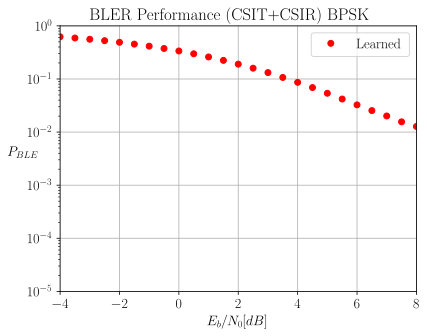

In [12]:
plt.rcParams.update({
    "text.usetex": True, # Comment this line if TeX is not installed on your machine
    "font.family" : 'serif',
    "font.size": 14
})
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_learned, label='Learned', color='red', marker="o", ls=" ")
# axes.semilogy(SNR_dB, BLER_uncoded_Alm)
axes.set_xlabel(r'$E_b / N_0[dB]$')
axes.set_ylabel(r'$P_{BLE}$', rotation=0)
axes.set_xlim(-4, 8)
axes.set_ylim(10**-5, 10**0)
axes.set_title(f'BLER Performance (CSIT+CSIR) BPSK')
axes.legend()
axes.grid()

> Recording the results for future use :

In [ ]:
# Saving the plots/ diagrams
fig.savefig("plots/eps_figs/deepCSIT_R.eps", transparent=True)